This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv. The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

Things to note - 
I have arranged the data so that the rare class has the label 1 and the common class has the label 0. 

The most important parameters are in cell 2 and 20. The main ones I tried experimenting with are num_out_of_filter and num_out_of_wrapper. In cell 2 I set the name of the record identifying number (I used a record number to keep track of things) and the name of the binary dependent variable. This particular version is set for a fraud problem.

I made sure my validation/out-of-time population and any other record exclusion is set correctly and as I want for the problem in cell 3. This define the records in the data file that I for whatever reason don't want to include in the feature selection process.

Cell 20 has the SequentialFeatureSelector (SFS) settings. I tried different wrapper models with different amounts of commplexity. I selected either forward or backward. The filter is pretty fast. The wrapper is what takes the most time. I found forward selection runs much faster than backward.

There's a parameter njobs that controls the # threads used in the wrapper. I set it to 1 for a single thread which works fine, but with njobs = -1, it lets the machine set the maximum # threads based on the CPU. However, with this setting the kernel may die because of memory. The njobs = -1 doesn't take into consideration the memory requirements.


In [1]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install LGBMClassifier

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement LGBMClassifier (from versions: none)
ERROR: No matching distribution found for LGBMClassifier
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [4]:
# set some parameters
num_files = 1 # this is the number of files for the candidate variables, usually just 1.
# num_out_of_filter is the number of variables that we'll keep from the filter. The more the better, but the wrapper will run slower.
# num_out_of_wrapper is the number we'll keep from the wrapper. These will then be our final variables for the models.
# I recommend set num_out_of_filter to be about 10 to 20% of the original # variables.
num_out_of_filter = 300
# I recommend set num_out_of_wrapper to be about 40, then look for a saturation of the model performance as variables are added.
# Then you can run it again with num_out_of_wrapper just a bit above this saturation point, not more than about twice this saturation number.
num_out_of_wrapper = 30
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [5]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'data/candidate_variables.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 85730] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 3515] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_out_of_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on data/candidate_variables.csv size is (98037, 2651)


<timed exec>:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Amount' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
data/candidate_variables.csv                                    variable  filter score
1                                     Fraud      1.000000
21                          Cardnum_total_1      0.591114
17                          Cardnum_count_1      0.576927
26                          Cardnum_count_3      0.572199
30                          Cardnum_total_3      0.569585
12                          Cardnum_total_0      0.555080
8                           Cardnum_count_0      0.529072
1580                  Cardnum_vdratio_1by60      0.519909
2089  Cardnum_unique_count_for_card_state_1      0.518606
2083    Cardnum_unique_count_for_card_zip_1      0.517208
1579                  Cardnum_vdratio_1by30      0.516476
35                          Cardnum_count_7      0.516399
39                          Cardnum_total_7      0.515987
2077    Cardnum_unique_count_for_Merch

In [6]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [7]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,Cardnum_total_1,0.591114
2,Cardnum_count_1,0.576927
3,Cardnum_count_3,0.572199
4,Cardnum_total_3,0.569585
5,Cardnum_total_0,0.555080
6,Cardnum_count_0,0.529072
7,Cardnum_vdratio_1by60,0.519909
8,Cardnum_unique_count_for_card_state_1,0.518606
9,Cardnum_unique_count_for_card_zip_1,0.517208


In [8]:
filter_score.tail(10)

,variable,filter score
2641,Merchdesc_Zip_unique_count_for_Merchdesc_State_14,0.000038
2642,Merchdesc_Zip_unique_count_for_Merchdesc_State_7,0.000038
2643,merch_zip_unique_count_for_merch_state_14,0.000025
2644,Card_Merchdesc_Zip_unique_count_for_Merchdesc_...,0.000013
2645,merch_zip_unique_count_for_merch_state_7,0.000013
2646,Merchnum_desc_Zip_unique_count_for_Merchnum_de...,0.000013
2647,merch_zip_unique_count_for_merch_state_3,0.000000
2648,Merchant_dominance_score,0.000000
2649,merch_zip_unique_count_for_merch_state_1,0.000000
2650,card_merch_unique_count_for_Cardnum_1,0.000000


In [9]:
filter_score.shape

(2651, 2)

In [ ]:
filter_score.head(80).to_csv('features/filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_out_of_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Cardnum_total_1', 'Cardnum_count_1', 'Cardnum_count_3', 'Cardnum_total_3', 'Cardnum_total_0', 'Cardnum_count_0', 'Cardnum_vdratio_1by60', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_card_zip_1', 'Cardnum_vdratio_1by30', 'Cardnum_count_7', 'Cardnum_total_7', 'Cardnum_unique_count_for_Merchnum_1', 'Card_dow_total_7', 'Card_dow_vdratio_0by60', 'Cardnum_unique_count_for_card_state_3', 'Card_dow_vdratio_0by30', 'Cardnum_unique_count_for_card_zip_3', 'Cardnum_max_1', 'Cardnum_unique_count_for_Merchnum_3', 'Card_dow_vdratio_0by14', 'Cardnum_vdratio_1by14', 'Cardnum_variability_max_0', 'Cardnum_variability_max_1', 'Cardnum_max_0', 'Card_dow_unique_count_for_merch_state_1', 'Card_dow_unique_count_for_merch_zip_1', 'Card_dow_vdratio_0by7', 'Cardnum_actual/toal_0', 'Card_dow_unique_count_for_Card_Merchdesc_1', 'Card_dow_unique_count_for_state_des_1', 'Card_dow_count_7', 'Cardnum_vdratio_1by7', 'Cardnum_unique_count_for_card_state_7', 'Cardnum_actual/toal_1',

In [ ]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('features/vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,Cardnum_total_1,Cardnum_count_1,Cardnum_count_3,Cardnum_total_3,Cardnum_total_0,Cardnum_count_0,Cardnum_vdratio_1by60,Cardnum_unique_count_for_card_state_1,Cardnum_unique_count_for_card_zip_1,Cardnum_vdratio_1by30,...,Merchnum_desc_State_total_3,Merchnum_desc_total_3,card_merch_total_amount_1_by_30,Card_Merchnum_State_total_amount_1_by_30,card_zip_total_1,state_des_total_1,Merchdesc_Zip_total_1,Cardnum_total_amount_0_by_14,Merchnum_desc_Zip_total_3,card_merch_total_1
Recnum,,,,,,,,,,,,,,,,,,,,,
3515,1551.02,3.0,7.0,1964.73,333.47,1.0,0.000641,3.0,3.0,0.001282,...,854.06,854.06,0.005670,0.005670,333.47,333.47,333.47,0.001838,854.06,333.47
3516,660.87,2.0,34.0,834.91,4.37,1.0,0.000140,2.0,2.0,0.000280,...,4.37,4.37,0.000292,0.000292,4.37,4.37,4.37,0.000263,4.37,4.37
3517,2904.08,7.0,14.0,8459.94,271.93,1.0,0.001768,4.0,5.0,0.003535,...,582.94,582.94,0.008423,0.008423,582.94,582.94,582.94,0.001312,582.94,582.94
3518,664.49,3.0,35.0,838.53,7.99,2.0,0.000417,2.0,2.0,0.000833,...,7.99,7.99,0.000530,0.000530,7.99,7.99,7.99,0.000480,7.99,7.99
3519,16.28,1.0,1.0,16.28,16.28,1.0,0.000011,1.0,1.0,0.000023,...,130.15,130.15,0.033333,0.033333,16.28,16.28,16.28,0.071429,130.15,16.28


In [12]:
df_keep.shape

(81893, 300)

In [13]:
Y.head()

,Fraud
Recnum,
3515,0.0
3516,0.0
3517,0.0
3518,0.0
3519,0.0


In [14]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [15]:
# Y = np.array(Y)
X = df_keep
print(Y)

[0. 0. 0. ... 0. 0. 0.]


In [16]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:51.570466


In [17]:
print(X.shape,Y.shape)

(81893, 300) (81893,)


In [18]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [19]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)

In [20]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [21]:
# This is a parallel running parameter. You can try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. You might experiment to see how big you can set this for your data on your machine.
njobs = -1

In [22]:
%%time
import warnings 
warnings.filterwarnings("ignore") 
# Keep the classifier settings simple. You don't need really good models, only good 
# enough to evaluate which variables help and in which order and combinations.

# If you're doing forward selection it's enough to stop at num_out_of_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_out_of_wrapper variables.

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
# clf = LGBMClassifier(n_estimators=20,num_leaves=4) # simple, fast nonlinear model for the wrapper
clf = CatBoostClassifier(verbose=0,iterations=20,depth=3)
sfs = SFS(clf,k_features=num_out_of_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for backward selection
sfs.fit(X,Y)

CPU times: user 15.7 s, sys: 4.24 s, total: 19.9 s
Wall time: 10min 42s


SequentialFeatureSelector(cv=2,
                          estimator=<catboost.core.CatBoostClassifier object at 0x3d43fee80>,
                          k_features=(30, 30), n_jobs=-1,
                          scoring=<function fdr at 0x3dce4f0d0>)

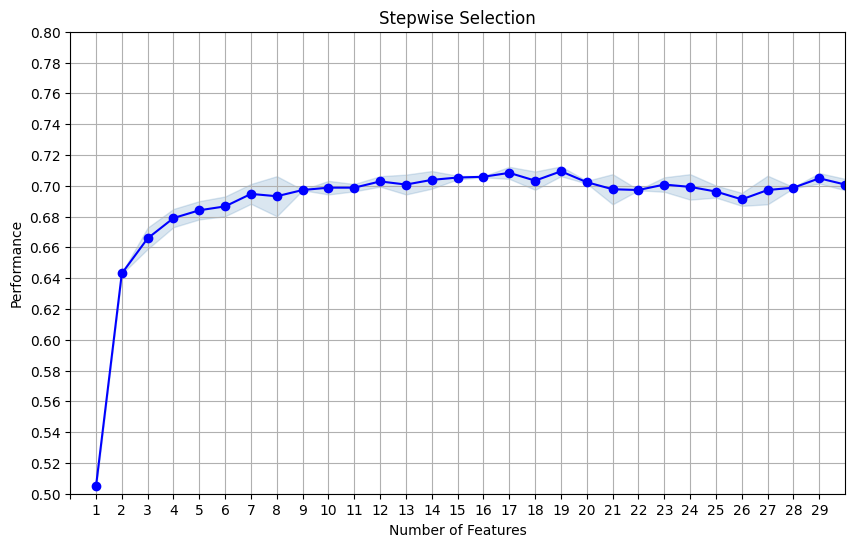

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(10, 6))
plt.xticks(np.arange(0, num_out_of_wrapper, step=1))
plt.yticks(np.arange(0,1,step=.02))
plt.ylim([.5,.8])
plt.xlim(0,num_out_of_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('features/performance_nvars.png')
plt.show()

In [24]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [25]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [26]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(7,)","[0.5030364372469636, 0.5065856129685917]",0.504811,"(Cardnum_unique_count_for_card_state_1,)",0.007635,0.001775,0.001775,1.0,Cardnum_unique_count_for_card_state_1
2,"(7, 256)","[0.6427125506072875, 0.6433637284701115]",0.643038,"(Cardnum_unique_count_for_card_state_1, Card_M...",0.001401,0.000326,0.000326,2.0,Card_Merchdesc_State_total_3
3,"(7, 123, 256)","[0.6589068825910931, 0.6727456940222898]",0.665826,"(Cardnum_unique_count_for_card_state_1, Card_M...",0.029772,0.006919,0.006919,3.0,Card_Merchnum_Zip_total_amount_1_by_60
4,"(7, 24, 123, 256)","[0.6730769230769231, 0.684903748733536]",0.67899,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.025443,0.005913,0.005913,4.0,Cardnum_max_0
5,"(7, 24, 123, 256, 258)","[0.6781376518218624, 0.6899696048632219]",0.684054,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.025454,0.005916,0.005916,5.0,card_merch_total_7
6,"(7, 24, 84, 123, 256, 258)","[0.680161943319838, 0.6930091185410334]",0.686586,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.027638,0.006424,0.006424,6.0,Cardnum_total_amount_0_by_60
7,"(7, 24, 84, 123, 240, 256, 258)","[0.6882591093117408, 0.7011144883485309]",0.694687,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.027656,0.006428,0.006428,7.0,card_zip_total_amount_0_by_60
8,"(7, 24, 84, 123, 240, 256, 258, 278)","[0.680161943319838, 0.7061803444782169]",0.693171,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.055974,0.013009,0.013009,8.0,card_state_max_7
9,"(7, 20, 24, 84, 123, 240, 256, 258, 278)","[0.6973684210526315, 0.6970618034447822]",0.697215,"(Cardnum_unique_count_for_card_state_1, Card_d...",0.00066,0.000153,0.000153,9.0,Card_dow_vdratio_0by14
10,"(7, 20, 24, 60, 84, 123, 240, 256, 258, 278)","[0.694331983805668, 0.7031408308004052]",0.698736,"(Cardnum_unique_count_for_card_state_1, Card_d...",0.018951,0.004404,0.004404,10.0,Card_dow_total_30


In [27]:
ordered_vars_FS.to_csv('data/Wrapper_selection_info.csv', index=False)

In [28]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('features/final_vars_list.csv',index=False)
vars_keep

1          Cardnum_unique_count_for_card_state_1
2                   Card_Merchdesc_State_total_3
3         Card_Merchnum_Zip_total_amount_1_by_60
4                                  Cardnum_max_0
5                             card_merch_total_7
6                   Cardnum_total_amount_0_by_60
7                  card_zip_total_amount_0_by_60
8                               card_state_max_7
9                         Card_dow_vdratio_0by14
10                             Card_dow_total_30
11                      High_Amount_For_Merchant
12                     Cardnum_variability_med_0
13                               Card_dow_avg_60
14                           card_state_total_14
15                       Card_dow_actual/toal_14
16    Card_dow_unique_count_for_Card_Merchdesc_1
17                        Card_dow_count_0_by_60
18                   Merchnum_desc_State_total_3
19        Cardnum_unique_count_for_card_state_60
20                     Cardnum_variability_max_3
21         Card_dow_

In [29]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
Cardnum_total_1,0.591114
Cardnum_count_1,0.576927
Cardnum_count_3,0.572199
Cardnum_total_3,0.569585
Cardnum_total_0,0.555080
...,...
Merchnum_desc_Zip_unique_count_for_Merchnum_desc_State_14,0.000013
merch_zip_unique_count_for_merch_state_3,0.000000
Merchant_dominance_score,0.000000


In [30]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
Cardnum_unique_count_for_card_state_1
Card_Merchdesc_State_total_3
Card_Merchnum_Zip_total_amount_1_by_60
Cardnum_max_0
card_merch_total_7


In [31]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [32]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('features/vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,Cardnum_unique_count_for_card_state_1,0.518606
1,2,Card_Merchdesc_State_total_3,0.259921
2,3,Card_Merchnum_Zip_total_amount_1_by_60,0.305897
3,4,Cardnum_max_0,0.492316
4,5,card_merch_total_7,0.259865
5,6,Cardnum_total_amount_0_by_60,0.370296
6,7,card_zip_total_amount_0_by_60,0.265548
7,8,card_state_max_7,0.253956
8,9,Card_dow_vdratio_0by14,0.502657
9,10,Card_dow_total_30,0.426803


In [33]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_3',
 'Card_Merchnum_Zip_total_amount_1_by_60',
 'Cardnum_max_0',
 'card_merch_total_7',
 'Cardnum_total_amount_0_by_60',
 'card_zip_total_amount_0_by_60',
 'card_state_max_7',
 'Card_dow_vdratio_0by14',
 'Card_dow_total_30',
 'High_Amount_For_Merchant',
 'Cardnum_variability_med_0',
 'Card_dow_avg_60',
 'card_state_total_14',
 'Card_dow_actual/toal_14',
 'Card_dow_unique_count_for_Card_Merchdesc_1',
 'Card_dow_count_0_by_60',
 'Merchnum_desc_State_total_3',
 'Cardnum_unique_count_for_card_state_60',
 'Cardnum_variability_max_3',
 'Card_dow_unique_count_for_merch_zip_1',
 'Cardnum_vdratio_0by7',
 'Cardnum_max_3',
 'Card_dow_unique_count_for_merch_state_14',
 'Card_Merchnum_desc_total_30',
 'Card_dow_count_30',
 'Cardnum_count_3',
 'Card_dow_unique_count_for_state_des_1',
 'Card_dow_unique_count_for_state_des_7',
 'Card_Merchnum_State_total_14',
 'Recnum',
 'Fraud']

In [34]:
filter_score

,filter score
variable,
Cardnum_total_1,0.591114
Cardnum_count_1,0.576927
Cardnum_count_3,0.572199
Cardnum_total_3,0.569585
Cardnum_total_0,0.555080
...,...
Merchnum_desc_Zip_unique_count_for_Merchnum_desc_State_14,0.000013
merch_zip_unique_count_for_merch_state_3,0.000000
Merchant_dominance_score,0.000000


In [35]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 13 s, sys: 1.4 s, total: 14.4 s
Wall time: 14.7 s


(98037, 2651)

In [36]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(98037, 32)


In [37]:
df_keep.to_csv('features/vars_final.csv',index=False)

In [38]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:11:50.105839


In [39]:
%pwd

'/Users/nujoumunus/SP25/Fraud_Analytics-1'